# Kapitel 6.4: Stoffe

Das Notebook ergänzt Kapitel 6.4 'Stoffe'.

# Import

In [1]:
import pandas as pd
import numpy as np

from resources_statistics import *
from resources_geschichtslyrik import *

import plotly.express as px
import plotly.graph_objects as go
from plotly.validators.scatter.marker import SymbolValidator

from tqdm.notebook import tqdm

In [2]:
meta = pd.read_json(r"../resources/meta.json")

# Merkmale hinzufügen

In [3]:
meta['stoffgebiet_count'] = [0 if pd.isna(x) else x.count('+')+1 for x in meta['stoffgebiet']]

In [4]:
kultur_stoffgebiete = [
    'Alltag', 'Arbeit', 'Architektur', 'Armut', 'Bildung', 
    'Denkmal', 'Erfindung/Innovation', 'Essen/Trinken', 'Fest', 'Finanzen',
    'Genie', 'Gesang', 'Gesundheit', 'Italiensehnsucht', 'Jagd',
    'Kunst', 'Landwirtschaft', 'Literatur', 'Moderne', 'Musik', 'Philosophie',
    'Reichtum', 'Sport', 'Sprache', 'Wissenschaft'
]

# Korpora

### Korpora erstellen

In [5]:
meta_anth = (
    meta
    .query("corpus=='anth'")
    .query("1850 <= year <= 1918")
    .query("geschichtslyrik == 1")
    .drop_duplicates(subset='author_title')
)
meta_anth_ratings = get_rating_table(meta_anth, mode = 'themes')
meta_anth_bin = binarize_meta(meta_anth)

In [6]:
modcanon_authors = ['Hofmannsthal, Hugo von', 'Rilke, Rainer Maria', 'George, Stefan', 'Heym, Georg']

meta_modcanon = (
    meta
    .query("author in @modcanon_authors")
    .query("1850 <= year <= 1918")
    .query("geschichtslyrik == 1")
    .drop_duplicates(subset='author_title')
)
meta_modcanon_ratings = get_rating_table(meta_modcanon, mode = 'themes')

In [7]:
muench_authors = ['Münchhausen, Börries von', 'Miegel, Agnes', 'Strauß und Torney, Lulu von']

meta_muench = (
    meta
    .query("author in @muench_authors")
    .query("1850 <= year <= 1918")
    .query("geschichtslyrik == 1")
    .drop_duplicates(subset='author_title')
)
meta_muench_ratings = get_rating_table(meta_muench, mode = 'themes')

In [8]:
sub_df = pd.DataFrame()
sub_names = ['Anthologien', 'Kanonisierte Moderne', 'Münchhausen-Kreis']
sub_metas = [meta_anth, meta_modcanon, meta_muench]
sub_ratings = [meta_anth_ratings, meta_modcanon_ratings, meta_muench_ratings]

### Merkmale berechnen

In [9]:
for this_name, this_meta, this_ratings in zip(sub_names, sub_metas, sub_ratings):
    this_ratings = this_ratings.copy()
    sub_df.loc[this_name, 'Jahr'] = round(this_meta['year'].mean(), 0)
        
    sub_df.loc[this_name, 'Texte'] = this_meta.shape[0]
    sub_df.loc[this_name, 'stoffgebiet_count'] = this_meta['stoffgebiet_count'].sum()
    sub_df.loc[this_name, 'stoffgebiet_per_text'] = sub_df.loc[this_name, 'stoffgebiet_count']/sub_df.loc[this_name, 'Texte']
    sub_df.loc[this_name, '1stoffgebiet_share'] = this_meta.query("stoffgebiet_count == 1").shape[0]/sub_df.loc[this_name, 'Texte']
    sub_df.loc[this_name, '2stoffgebiet_share'] = this_meta.query("stoffgebiet_count == 2").shape[0]/sub_df.loc[this_name, 'Texte']
    sub_df.loc[this_name, '3stoffgebiet_share'] = this_meta.query("stoffgebiet_count >= 3").shape[0]/sub_df.loc[this_name, 'Texte']
    
    top_stoffgebiete = meta_anth_ratings['type'].value_counts().index.tolist()[:10]
    for stoffgebiet in top_stoffgebiete:
        stoffgebiet_count = this_meta.query("stoffgebiet.str.contains(@stoffgebiet)").shape[0]
        stoffgebiet_neutral_count = this_ratings.query("type==@stoffgebiet and rating == '0'").shape[0]
        stoffgebiet_positiv_count = this_ratings.query("type==@stoffgebiet and rating == '1'").shape[0]
        stoffgebiet_negativ_count = this_ratings.query("type==@stoffgebiet and rating == '2'").shape[0]
        stoffgebiet_ambivalent_count = this_ratings.query("type==@stoffgebiet and rating == '3'").shape[0]
        
        sub_df.loc[this_name, f'{stoffgebiet}_count'] = stoffgebiet_count
        sub_df.loc[this_name, f'{stoffgebiet}_share_texts'] = stoffgebiet_count/sub_df.loc[this_name, 'Texte']
        sub_df.loc[this_name, f'{stoffgebiet}_share_stoffgebiete'] = stoffgebiet_count/sub_df.loc[this_name, 'stoffgebiet_count']
        if stoffgebiet_count > 0:
            sub_df.loc[this_name, f'{stoffgebiet}_neutral_share'] = stoffgebiet_neutral_count/stoffgebiet_count
            sub_df.loc[this_name, f'{stoffgebiet}_positiv_share'] = stoffgebiet_positiv_count/stoffgebiet_count
            sub_df.loc[this_name, f'{stoffgebiet}_negativ_share'] = stoffgebiet_negativ_count/stoffgebiet_count
            sub_df.loc[this_name, f'{stoffgebiet}_ambivalent_share'] = stoffgebiet_ambivalent_count/stoffgebiet_count
            
    stoffgebiete_nokrieg_count = sub_df.loc[this_name, 'stoffgebiet_count'] - sub_df.loc[this_name, 'Militär/Krieg_count'] 
    sub_df.loc[this_name, 'stoffgebiet_neutral_count'] = this_ratings.query("type!='Militär/Krieg' and rating == '0'").shape[0]
    sub_df.loc[this_name, 'stoffgebiet_positiv_count'] = this_ratings.query("type!='Militär/Krieg' and rating == '1'").shape[0]
    sub_df.loc[this_name, 'stoffgebiet_negativ_count'] = this_ratings.query("type!='Militär/Krieg' and rating == '2'").shape[0]
    sub_df.loc[this_name, 'stoffgebiet_ambivalent_count'] = this_ratings.query("type!='Militär/Krieg' and rating == '3'").shape[0]
    sub_df.loc[this_name, 'stoffgebiet_neutral_share'] = sub_df.loc[this_name, 'stoffgebiet_neutral_count']/stoffgebiete_nokrieg_count
    sub_df.loc[this_name, 'stoffgebiet_positiv_share'] = sub_df.loc[this_name, 'stoffgebiet_positiv_count']/stoffgebiete_nokrieg_count
    sub_df.loc[this_name, 'stoffgebiet_negativ_share'] = sub_df.loc[this_name, 'stoffgebiet_negativ_count']/stoffgebiete_nokrieg_count
    sub_df.loc[this_name, 'stoffgebiet_ambivalent_share'] = sub_df.loc[this_name, 'stoffgebiet_ambivalent_count']/stoffgebiete_nokrieg_count
    
    this_ratings['author_title'] = this_ratings['author'] + ' – ' + this_ratings['title']
    this_ratings['type'] = ['Kultur' if x in kultur_stoffgebiete else x for x in this_ratings['type']]
    this_ratings = this_ratings.drop_duplicates(subset = ['author_title', 'type'])
    sub_df.loc[this_name, 'kultur_count'] = this_ratings.query("type=='Kultur'").shape[0]
    sub_df.loc[this_name, 'kultur_share_texts'] = sub_df.loc[this_name, 'kultur_count']/sub_df.loc[this_name, 'Texte']
    sub_df.loc[this_name, 'kultur_share_stoffgebiete'] = sub_df.loc[this_name, 'kultur_count']/this_ratings.shape[0]

# Zeitverlauf

In [10]:
ts = pd.DataFrame()
ts.index = pd.Series(range(1850, 1919), name = 'year')

In [11]:
ts['text_count'] = meta_anth.groupby('year').size()
ts['text_count'] = ts['text_count'].fillna(0)
ts['text_sum'] = smooth(ts['text_count'], mode = 'sum')

In [12]:
ts['1stoffgebiet_count'] = [meta_anth.query("year == @x and stoffgebiet_count == 1").shape[0] for x in ts.index]
ts['1stoffgebiet_sum'] = smooth(ts['1stoffgebiet_count'], mode = 'sum')
ts['1stoffgebiet_share_smoothed'] = ts['1stoffgebiet_sum']/ts['text_sum']
ts['1stoffgebiet_share_smoothed_low'] = [proportion_confint(x, y, 0.1)[0] for x, y in zip(ts['1stoffgebiet_sum'], ts['text_sum'])]
ts['1stoffgebiet_share_smoothed_high'] = [proportion_confint(x, y, 0.1)[1] for x, y in zip(ts['1stoffgebiet_sum'], ts['text_sum'])]

ts['2stoffgebiet_count'] = [meta_anth.query("year == @x and stoffgebiet_count == 2").shape[0] for x in ts.index]
ts['2stoffgebiet_sum'] = smooth(ts['2stoffgebiet_count'], mode = 'sum')
ts['2stoffgebiet_share_smoothed'] = ts['2stoffgebiet_sum']/ts['text_sum']
ts['2stoffgebiet_share_smoothed_low'] = [proportion_confint(x, y, 0.1)[0] for x, y in zip(ts['2stoffgebiet_sum'], ts['text_sum'])]
ts['2stoffgebiet_share_smoothed_high'] = [proportion_confint(x, y, 0.1)[1] for x, y in zip(ts['2stoffgebiet_sum'], ts['text_sum'])]

ts['3stoffgebiet_count'] = [meta_anth.query("year == @x and stoffgebiet_count >= 3").shape[0] for x in ts.index]
ts['3stoffgebiet_sum'] = smooth(ts['3stoffgebiet_count'], mode = 'sum')
ts['3stoffgebiet_share_smoothed'] = ts['3stoffgebiet_sum']/ts['text_sum']
ts['3stoffgebiet_share_smoothed_low'] = [proportion_confint(x, y, 0.1)[0] for x, y in zip(ts['3stoffgebiet_sum'], ts['text_sum'])]
ts['3stoffgebiet_share_smoothed_high'] = [proportion_confint(x, y, 0.1)[1] for x, y in zip(ts['3stoffgebiet_sum'], ts['text_sum'])]

ts['stoffgebiet_count'] = [meta_anth.query("year == @x")['stoffgebiet_count'].sum() for x in ts.index]
ts['stoffgebiet_sum'] = smooth(ts['stoffgebiet_count'], mode = 'sum')

ts['krieg_count'] = [meta_anth.query("year == @x and stoffgebiet.str.contains('Krieg')").shape[0] for x in ts.index]
ts['krieg_sum'] = smooth(ts['krieg_count'], mode = 'sum')
ts['krieg_share_smoothed'] = ts['krieg_sum']/ts['stoffgebiet_sum']

ts['politik_count'] = [meta_anth.query("year == @x and stoffgebiet.str.contains('Politik')").shape[0] for x in ts.index]
ts['politik_sum'] = smooth(ts['politik_count'], mode = 'sum')
ts['politik_share_smoothed'] = ts['politik_sum']/ts['stoffgebiet_sum']

ts['religion_count'] = [meta_anth.query("year == @x and stoffgebiet.str.contains('Religion')").shape[0] for x in ts.index]
ts['religion_sum'] = smooth(ts['religion_count'], mode = 'sum')
ts['religion_share_smoothed'] = ts['religion_sum']/ts['stoffgebiet_sum']

ts['tod_count'] = [meta_anth.query("year == @x and stoffgebiet.str.contains('Tod')").shape[0] for x in ts.index]
ts['tod_sum'] = smooth(ts['tod_count'], mode = 'sum')
ts['tod_share_smoothed'] = ts['tod_sum']/ts['stoffgebiet_sum']

for  year in ts.index:
    this_ratings = get_rating_table(meta = meta_anth.query("year == @year"), mode = 'themes')
    if this_ratings.shape[0] > 0:
        ts.at[year, 'krieg_neutral_count'] = this_ratings.query("type == 'Militär/Krieg' & rating == '0'").shape[0]
        ts.at[year, 'krieg_positiv_count'] = this_ratings.query("type == 'Militär/Krieg' & rating == '1'").shape[0]
        ts.at[year, 'krieg_negativ_count'] = this_ratings.query("type == 'Militär/Krieg' & rating == '2'").shape[0]
        ts.at[year, 'krieg_ambivalent_count'] = this_ratings.query("type == 'Militär/Krieg' & rating == '3'").shape[0]
ts['krieg_neutral_sum'] = smooth(ts['krieg_neutral_count'], mode = 'sum')
ts['krieg_neutral_share_smoothed'] = ts['krieg_neutral_sum']/ts['krieg_sum']
ts['krieg_positiv_sum'] = smooth(ts['krieg_positiv_count'], mode = 'sum')
ts['krieg_positiv_share_smoothed'] = ts['krieg_positiv_sum']/ts['krieg_sum']
ts['krieg_positiv_share_smoothed_low'] = [proportion_confint(x, y, 0.1)[0] for x, y in zip(ts['krieg_positiv_sum'], ts['krieg_sum'])]
ts['krieg_positiv_share_smoothed_high'] = [proportion_confint(x, y, 0.1)[1] for x, y in zip(ts['krieg_positiv_sum'], ts['krieg_sum'])]
ts['krieg_negativ_sum'] = smooth(ts['krieg_negativ_count'], mode = 'sum')
ts['krieg_negativ_share_smoothed'] = ts['krieg_negativ_sum']/ts['krieg_sum']
ts['krieg_ambivalent_sum'] = smooth(ts['krieg_ambivalent_count'], mode = 'sum')
ts['krieg_ambivalent_share_smoothed'] = ts['krieg_ambivalent_sum']/ts['krieg_sum']

ts['stoffgebiet_nokrieg_count'] = ts['stoffgebiet_count']-ts['krieg_count']
ts['stoffgebiet_nokrieg_sum'] = smooth(ts['stoffgebiet_nokrieg_count'], mode = 'sum')
for year in ts.index:
    this_ratings = get_rating_table(meta = meta_anth.query("year == @year"), mode = 'themes')
    if this_ratings.shape[0] > 0:
        ts.at[year, 'ratings_neutral_count'] = this_ratings.query("type!='Militär/Krieg' and rating == '0'").shape[0]
        ts.at[year, 'ratings_positiv_count'] = this_ratings.query("type!='Militär/Krieg' and rating == '1'").shape[0]
        ts.at[year, 'ratings_negativ_count'] = this_ratings.query("type!='Militär/Krieg' and rating == '2'").shape[0]
        ts.at[year, 'ratings_ambivalent_count'] = this_ratings.query("type!='Militär/Krieg' and rating == '3'").shape[0]
ts['ratings_neutral_sum'] = smooth(ts['ratings_neutral_count'], mode = 'sum')
ts['ratings_neutral_share_smoothed'] = ts['ratings_neutral_sum']/ts['stoffgebiet_nokrieg_sum']
ts['ratings_positiv_sum'] = smooth(ts['ratings_positiv_count'], mode = 'sum')
ts['ratings_positiv_share_smoothed'] = ts['ratings_positiv_sum']/ts['stoffgebiet_nokrieg_sum']
ts['ratings_negativ_sum'] = smooth(ts['ratings_negativ_count'], mode = 'sum')
ts['ratings_negativ_share_smoothed'] = ts['ratings_negativ_sum']/ts['stoffgebiet_nokrieg_sum']
ts['ratings_ambivalent_sum'] = smooth(ts['ratings_ambivalent_count'], mode = 'sum')
ts['ratings_ambivalent_share_smoothed'] = ts['ratings_ambivalent_sum']/ts['stoffgebiet_nokrieg_sum']

for year in ts.index:
    this_ratings = get_rating_table(meta = meta_anth.query("year == @year"), mode = 'themes').copy()
    this_ratings['author_title'] = this_ratings['author'] + ' – ' + this_ratings['title']
    this_ratings['type'] = ['Kultur' if x in kultur_stoffgebiete else x for x in this_ratings['type']]
    this_ratings = this_ratings.drop_duplicates(subset = ['author_title', 'type'])
    ts.at[year, 'kultur_count'] = this_ratings.query("type == 'Kultur'").shape[0]
    ts.at[year, 'stoffgebiet_kulturunified_count'] = this_ratings.shape[0]
ts['stoffgebiet_kulturunified_sum'] = smooth(ts['stoffgebiet_kulturunified_count'], mode = 'sum')
ts['kultur_sum'] = smooth(ts['kultur_count'], mode = 'sum')
ts['kultur_share_smoothed'] = ts['kultur_sum']/ts['stoffgebiet_kulturunified_sum']

# Anzahl

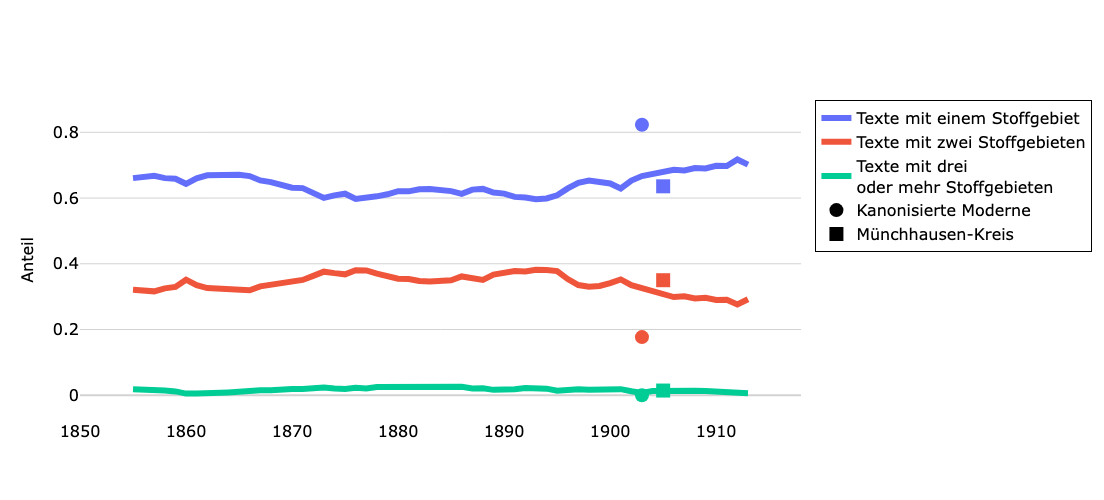

In [58]:
meta_plot = ts[[
    '1stoffgebiet_share_smoothed', 
    '2stoffgebiet_share_smoothed', 
    '3stoffgebiet_share_smoothed'
]]
meta_plot.columns = [
    'Texte mit einem Stoffgebiet', 
    'Texte mit zwei Stoffgebieten', 
    'Texte mit drei<br>oder mehr Stoffgebieten'
]
# save_ts_data(meta_plot, prefix="06_04_Anzahl_Stoffgebiete_")

fig = create_ts_plot(
    data = meta_plot, 
    columns = meta_plot.columns, 
    y_axis_title = 'Anteil',
    add_corporas = sub_df, add_corpora_names = sub_names,
    add_corpora_categories = ['1stoffgebiet_share', '2stoffgebiet_share', '3stoffgebiet_share']
)
fig = update_fig_for_publication(fig)
fig.write_image(f"plots/6.4.1 Anzahl behandelter Stoffgebiete im Zeitverlauf.pdf")
fig.show()

In [14]:
main_feature = 'stoffgebiet_count'

In [15]:
meta_anth_bin.corr(numeric_only=True)[main_feature].sort_values(ascending = False).head(20)

stoffgebiet_count         1.000000
stoffgebiet_positiv       0.298947
tod                       0.271463
stoffgebiet_negativ       0.261819
stoffgebiet_neutral       0.249774
religion                  0.193423
politik                   0.191813
nation_volk_d_positiv     0.151197
liebe                     0.146108
kollektiv_negativ         0.133083
zeitebenen                0.132739
stoffgebiet_ambivalent    0.128008
mittelraum_count          0.123801
nation_volk_d             0.109854
words                     0.102209
ereignis                  0.088353
marker_count              0.085259
kleinraum_count           0.084622
tod_positiv               0.082412
persmarker_vorhanden      0.077888
Name: stoffgebiet_count, dtype: float64

In [16]:
meta_anth_bin.corr(numeric_only=True)[main_feature].sort_values(ascending = True).head(20)

liebe_positiv                    -0.177151
tod_negativ                      -0.106305
krieg_positiv                    -0.104908
nation_volk_d_negativ            -0.104290
geschichtsauffassung_positiv     -0.068672
neuzeit                          -0.061192
nogenre                          -0.055455
verfremdung                      -0.053236
kollektiv_count                  -0.050258
ende                             -0.038850
zeit_mitte                       -0.037505
ortmarker_vorhanden              -0.037072
beginn                           -0.035379
lied                             -0.034982
kollektiv_positiv                -0.034060
wissen_identisch                 -0.034059
sonett                           -0.032882
wissen                           -0.031754
entity_neutral                   -0.030090
sprechakt_auffordern_vorhanden   -0.025803
Name: stoffgebiet_count, dtype: float64

In [17]:
threshold = 0.15

bin_comp_features = get_features(meta_anth_bin.corr(numeric_only=True)[main_feature], threshold = threshold, mode = 'bin')
cont_comp_features = get_features(meta_anth_bin.corr(numeric_only=True)[main_feature], threshold = threshold, mode = 'cont')

In [18]:
results = relations_contbin(
    meta = meta_anth_bin, 
    main_feature = main_feature,
    comp_features = bin_comp_features
)

In [19]:
round(results.sort_values(by = 'pointbiserialr_corr', ascending = False), 5).query("pointbiserialr_corr >= @threshold")

,wenn stoffgebiet_count = 0: Anteil Texte mit Feature = ...,wenn stoffgebiet_count = 1: Anteil Texte mit Feature = ...,wenn stoffgebiet_count = 2: Anteil Texte mit Feature = ...,wenn stoffgebiet_count = 3: Anteil Texte mit Feature = ...,wenn stoffgebiet_count > 3: Anteil Texte mit Feature = ...,pointbiserialr_corr,pointbiserialr_p,ttest_p,cohens_d,mannwhitneyu_stat,mannwhitneyu_p
stoffgebiet_positiv,0 [0/0],0.49622799664710815 [592/1193],0.3376 [211/625],0.3548387096774194 [11/31],1.0 [1/1],0.29895,0.00000,0.49147,0.03372,354665.0,0.35903
tod,0 [0/0],0.051969823973176864 [62/1193],0.232 [145/625],0.3225806451612903 [10/31],0.0 [0/1],0.27146,0.00000,0.00000,-0.85913,104290.0,0.00000
stoffgebiet_negativ,0 [0/0],0.18943839061190276 [226/1193],0.2912 [182/625],0.3225806451612903 [10/31],1.0 [1/1],0.26182,0.00000,0.00000,-0.34553,239605.0,0.00000
stoffgebiet_neutral,0 [0/0],0.17015926236378875 [203/1193],0.1776 [111/625],0.2903225806451613 [9/31],1.0 [1/1],0.24977,0.00000,0.00972,-0.15223,220036.5,0.03043
religion,0 [0/0],0.09388097233864208 [112/1193],0.232 [145/625],0.3225806451612903 [10/31],0.0 [0/1],0.19342,0.00000,0.00000,-0.53968,154865.0,0.00000
politik,0 [0/0],0.10477787091366303 [125/1193],0.2304 [144/625],0.45161290322580644 [14/31],0.0 [0/1],0.19181,0.00000,0.00000,-0.51293,166482.0,0.00000
nation_volk_d_positiv,0 [0/0],0.6818181818181818 [15/22],0.7333333333333333 [22/30],1.0 [3/3],1.0 [1/1],0.15120,0.26599,0.26599,-0.36974,260.5,0.33175


In [20]:
results = relations_contbin_ratings(meta_anth_bin, main_feature, max_count = 3)
results.sort_values(by = 'pointbiserialr_corr')

  0%|          | 0/14 [00:00<?, ?it/s]

,wenn stoffgebiet_count = 1: Anteil mit Feature = ...,wenn stoffgebiet_count = 2: Anteil mit Feature = ...,wenn stoffgebiet_count = 3: Anteil mit Feature = ...,pointbiserialr_corr,pointbiserialr_p,mannwhitneyu_stat,mannwhitneyu_p
stoffgebiet_positiv,0.4962 [592/1193],0.4424 [553/1250],0.4086 [38/93],-0.059239,0.002820,754693.0,0.003110
kollektiv_positiv,0.3883 [278/716],0.3343 [112/335],0.4167 [5/12],-0.037633,0.219991,126416.5,0.138648
entity_neutral,0.3095 [772/2494],0.269 [364/1353],0.303 [20/66],-0.036774,0.021374,1528936.0,0.012939
unbekanntes_individuum_negativ,0.1388 [54/389],0.1087 [25/230],0.1667 [2/12],-0.032366,0.417008,21072.5,0.354159
stoffgebiet_ambivalent,0.1442 [172/1193],0.1248 [156/1250],0.0968 [9/93],-0.031760,0.109539,354027.5,0.101758
bekanntes_individuum_negativ,0.1375 [174/1265],0.1371 [99/722],0.0789 [3/38],-0.010307,0.642961,238959.0,0.752280
unbekanntes_individuum_positiv,0.3445 [134/389],0.3435 [79/230],0.3333 [4/12],-0.002214,0.955735,44834.5,0.963631
entity_positiv,0.4707 [1174/2494],0.493 [667/1353],0.4394 [29/66],0.013854,0.386112,1944815.5,0.283551
entity_negativ,0.1596 [398/2494],0.1737 [235/1353],0.1667 [11/66],0.014873,0.352133,1076685.5,0.292580
entity_ambivalent,0.0601 [150/2494],0.0643 [87/1353],0.0909 [6/66],0.017976,0.260735,460310.0,0.389143


In [21]:
results = relations_contcont(
    meta = meta_anth_bin, 
    main_feature = main_feature,
    comp_features = cont_comp_features + ['words']
)

In [22]:
round(results.sort_values(by = 'pearsonr_corr', ascending = False), 4)

,wenn stoffgebiet_count = 0: Mittelwert Feature = ...,wenn stoffgebiet_count = 1: Mittelwert Feature = ...,wenn stoffgebiet_count = 2: Mittelwert Feature = ...,wenn stoffgebiet_count = 3: Mittelwert Feature = ...,wenn stoffgebiet_count > 3: Mittelwert Feature = ...,pearsonr_corr,pearsonr_p
words,NaN,297.2928,337.7221,410.6207,248.0,0.1022,0.0


# Häufigste Stoffgebiete

In [23]:
top_stoffgebiete = pd.DataFrame()

top_stoffgebiete['Stoffgebiet'] = meta_anth_ratings['type'].value_counts().index
top_stoffgebiete['Anzahl'] = meta_anth_ratings['type'].value_counts().tolist()
top_stoffgebiete['Anteil an Texten'] = top_stoffgebiete['Anzahl'] / meta_anth.shape[0]
top_stoffgebiete['Anteil an Stoffgebieten'] = top_stoffgebiete['Anzahl'] / top_stoffgebiete['Anzahl'].sum()

In [24]:
top_stoffgebiete.head(20)

,Stoffgebiet,Anzahl,Anteil an Texten,Anteil an Stoffgebieten
0,Militär/Krieg,797,0.430811,0.313780
1,Politik,284,0.153514,0.111811
2,Religion,267,0.144324,0.105118
3,Tod,217,0.117297,0.085433
4,Liebe,63,0.034054,0.024803
5,Literatur,60,0.032432,0.023622
6,Nation/Volk-D,56,0.030270,0.022047
7,Geschichte,48,0.025946,0.018898
8,Mord,44,0.023784,0.017323
9,Recht,40,0.021622,0.015748


In [25]:
# Häufigste 10 Stoffgebiete (Anthologiekorpus)
print(f"Anteil an Stoffgebieten : {top_stoffgebiete.head(10)['Anteil an Stoffgebieten'].sum()}")

Anteil an Stoffgebieten : 0.7385826771653543


In [26]:
# Häufigste 4 Stoffgebiete (Anthologiekorpus)
print(f"Anteil an Stoffgebieten               : {top_stoffgebiete.head(4)['Anteil an Stoffgebieten'].sum()}")

krieg_titles = meta_anth.query("stoffgebiet.str.contains('Krieg')")['author_title'].tolist()
politik_titles = meta_anth.query("stoffgebiet.str.contains('Politik')")['author_title'].tolist()
religion_titles = meta_anth.query("stoffgebiet.str.contains('Religion')")['author_title'].tolist()
tod_titles = meta_anth.query("stoffgebiet.str.contains('Tod')")['author_title'].tolist()
all_titles = set(krieg_titles + politik_titles + religion_titles + tod_titles)

print(f"Texte mit min. einem der Stoffgebiete : {len(all_titles)/meta_anth.shape[0]}")

Anteil an Stoffgebieten               : 0.6161417322834646
Texte mit min. einem der Stoffgebiete : 0.72


In [27]:
meta_plot = ts[[
    'krieg_share_smoothed', 
    'politik_share_smoothed', 
    'religion_share_smoothed',
    'tod_share_smoothed'
]]
meta_plot.columns = [
    'Militär/Krieg', 
    'Politik', 
    'Religion',
    'Tod'
]
save_ts_data(meta_plot, prefix="06_04_Haeufigste_Stoffgebiete_")

fig = create_ts_plot(
    data = meta_plot, 
    columns = meta_plot.columns, 
    y_axis_title = 'Anteil an Stoffgebiet-Annotationen',
    add_corporas = sub_df, add_corpora_names = sub_names,
    add_corpora_categories = ['Militär/Krieg_share_stoffgebiete', 'Politik_share_stoffgebiete', 'Religion_share_stoffgebiete', 'Tod_share_stoffgebiete']
)
fig = update_fig_for_publication(fig)
fig.write_image(f"plots/6.4.2 Häufigste Stoffgebiete im Zeitverlauf.pdf")
fig.show()

In [28]:
# Militär/Krieg 1900–1918
meta_test = meta_anth_bin.copy()
meta_test['later_1905'] = [1 if year >= 1905 else 0 for year in meta_test['year']]
crosstab = pd.crosstab(meta_test['later_1905'], meta_test['krieg'], margins=True)
crosstab['1_rel'] = crosstab[1]/crosstab['All']
chi2 = chi2_contingency(pd.crosstab(meta_test['later_1905'], meta_test['krieg']))
print(crosstab)
print(f"chi2 p = {chi2[1]}")
print("\n")

meta_time = meta_anth_bin.query("1905 <= year <= 1918")
authors = pd.DataFrame({
    'texts' : meta_time.groupby('author').size(),
    'krieg_abs' : meta_time.groupby('author')['krieg'].sum(),
})
authors['krieg_rel'] = authors['krieg_abs']/authors['texts']
print(authors.query("texts >= 5").sort_values(by='krieg_rel', ascending=False))

print("\n")
relevant_authors = ['Schüler, Gustav', 'Geißler, Max', 'Münchhausen, Börries von', 'Schrutz, Demetrius']
meta_authors = meta_time.query("author.isin(@relevant_authors) and krieg == 1")
meta_authors[['author', 'title', 'year', 'beginn', 'ende']].sort_values(by='author')

krieg          0    1   All     1_rel
later_1905                           
0            970  687  1657  0.414605
1             83  110   193  0.569948
All         1053  797  1850  0.430811
chi2 p = 5.171402285106389e-05


                          texts  krieg_abs  krieg_rel
author                                               
Schüler, Gustav               7          7   1.000000
Geißler, Max                 11         10   0.909091
Münchhausen, Börries von      9          7   0.777778
Schrutz, Demetrius           10          7   0.700000
Lissauer, Ernst              15         10   0.666667
Weber, Ernst                  7          4   0.571429
Löns, Hermann                 7          3   0.428571
Lienert, Meinrad              5          2   0.400000
Gaudy, Alice von              5          2   0.400000
Hohlbaum, Robert              6          2   0.333333
Blunck, Hans Friedrich        6          1   0.166667




,author,title,year,beginn,ende
1330,"Geißler, Max",Königsdank,1908.0,1757.0,1757.0
1343,"Geißler, Max",Die Schlacht auf dem Schirlenhof,1909.0,1870.0,1870.0
1346,"Geißler, Max",Drei gute Kameraden,1909.0,1870.0,1871.0
1352,"Geißler, Max",Moltke,1909.0,1870.0,1870.0
1370,"Geißler, Max",Die Mutter,1909.0,1900.0,1900.0
1445,"Geißler, Max",Der Schmied von Solingen,1909.0,1757.0,1757.0
1455,"Geißler, Max",Schandmal,1909.0,1810.0,1810.0
1459,"Geißler, Max",Blüchers Predigt,1908.0,1813.0,1813.0
1472,"Geißler, Max",Die Kaiserschmiede von Sedan,1909.0,1870.0,1871.0
1482,"Geißler, Max",Die stille Wacht,1909.0,1900.0,1900.0


In [29]:
# Tod 1888–1898
meta_time = meta_anth.query("1888 <= year <= 1898")
meta_death = meta_time.query("stoffgebiet.str.contains('Tod')")
meta_death_people = meta_death.query(
    "entity_full.str.contains('Wilhelm I. (Deutsches Reich)', regex = False) or " 
    "entity_full.str.contains('Friedrich III. (Deutsches Reich)', regex = False) or "
    "entity_full.str.contains('Otto von Bismarck', regex = False)"
)

print(f"Texte 1888–1898                                              : {meta_time.shape[0]}")
print(f"davon über Stoffgebiet Tod                                   : {meta_death.shape[0]}")
print(f"davon mit Bezug auf Wilhelm I., Friedrich III. oder Bismarck : {meta_death_people.shape[0]}\n")

meta_death[['author', 'title', 'year']].sort_values(by='year')

Texte 1888–1898                                              : 206
davon über Stoffgebiet Tod                                   : 47
davon mit Bezug auf Wilhelm I., Friedrich III. oder Bismarck : 13



,author,title,year
12646,"Gerok, Karl",Zu Kaiser Friedrichs Heimgang,1888.0
12655,"Gerok, Karl",Kaiser Wilhelms Römerfahrt (Konradins Sühne),1888.0
13426,"Weck, Gustav",Nun hat er Zeit,1888.0
14219,"Dahn, Felix","Lebe wohl nun, Kaiser Wilhelm",1888.0
14217,"Walling, Günther",Kaiser Wilhelm I.,1888.0
14634,"Evers, Matthias",Kaiser Friedrich,1888.0
15353,"Avenarius, Ferdinand",Wilhelm I.,1888.0
17589,"Rittershaus, Emil",Ein Scheidegruß für das Jahr 1888,1888.0
13865,"Möser, Albert",Die Locke der Konstanze,1889.0
15384,"Liliencron, Detlev von",Im Tal von Roncesvalles,1889.0


In [30]:
# Moderne Kanon
top_stoffgebiete = pd.DataFrame()
top_stoffgebiete['Stoffgebiet'] = meta_modcanon_ratings['type'].value_counts().index
top_stoffgebiete['Anzahl'] = meta_modcanon_ratings['type'].value_counts().tolist()
top_stoffgebiete['Anteil an Texten'] = top_stoffgebiete['Anzahl'] / meta_modcanon.shape[0]
top_stoffgebiete['Anteil an Stoffgebieten'] = top_stoffgebiete['Anzahl'] / top_stoffgebiete['Anzahl'].sum()
print(top_stoffgebiete.head(10))
print("\n")

print(f"Fokus Militär/Krieg, Politik, Tod, Religion:")
print(f"Anteil an Stoffgebieten               : {top_stoffgebiete.head(4)['Anteil an Stoffgebieten'].sum()}")

krieg_titles = meta_modcanon.query("stoffgebiet.str.contains('Krieg')")['author_title'].tolist()
politik_titles = meta_modcanon.query("stoffgebiet.str.contains('Politik')")['author_title'].tolist()
religion_titles = meta_modcanon.query("stoffgebiet.str.contains('Religion')")['author_title'].tolist()
tod_titles = meta_modcanon.query("stoffgebiet.str.contains('Tod')")['author_title'].tolist()
all_titles = set(krieg_titles + politik_titles + religion_titles + tod_titles)

print(f"Texte mit min. einem der Stoffgebiete : {len(all_titles)/meta_modcanon.shape[0]}")

           Stoffgebiet  Anzahl  Anteil an Texten  Anteil an Stoffgebieten
0        Militär/Krieg      41          0.362832                 0.308271
1            Rittertum      13          0.115044                 0.097744
2             Religion      12          0.106195                 0.090226
3              Politik      10          0.088496                 0.075188
4           Geschichte       9          0.079646                 0.067669
5                  Tod       8          0.070796                 0.060150
6  Aufstand/Revolution       4          0.035398                 0.030075
7            Literatur       4          0.035398                 0.030075
8                Liebe       3          0.026549                 0.022556
9                Kunst       3          0.026549                 0.022556


Fokus Militär/Krieg, Politik, Tod, Religion:
Anteil an Stoffgebieten               : 0.5714285714285714
Texte mit min. einem der Stoffgebiete : 0.6106194690265486


In [31]:
# Münchhausen
top_stoffgebiete = pd.DataFrame()
top_stoffgebiete['Stoffgebiet'] = meta_muench_ratings['type'].value_counts().index
top_stoffgebiete['Anzahl'] = meta_muench_ratings['type'].value_counts().tolist()
top_stoffgebiete['Anteil an Texten'] = top_stoffgebiete['Anzahl'] / meta_muench.shape[0]
top_stoffgebiete['Anteil an Stoffgebieten'] = top_stoffgebiete['Anzahl'] / top_stoffgebiete['Anzahl'].sum()
print(top_stoffgebiete.head(10))
print("\n")

print(f"Fokus Militär/Krieg, Politik, Tod, Religion:")
print(f"Anteil an Stoffgebieten               : {top_stoffgebiete.head(4)['Anteil an Stoffgebieten'].sum()}")

krieg_titles = meta_muench.query("stoffgebiet.str.contains('Krieg')")['author_title'].tolist()
politik_titles = meta_muench.query("stoffgebiet.str.contains('Politik')")['author_title'].tolist()
religion_titles = meta_muench.query("stoffgebiet.str.contains('Religion')")['author_title'].tolist()
tod_titles = meta_muench.query("stoffgebiet.str.contains('Tod')")['author_title'].tolist()
all_titles = set(krieg_titles + politik_titles + religion_titles + tod_titles)

print(f"Texte mit min. einem der Stoffgebiete : {len(all_titles)/meta_muench.shape[0]}")

          Stoffgebiet  Anzahl  Anteil an Texten  Anteil an Stoffgebieten
0       Militär/Krieg      49          0.350000                 0.253886
1                 Tod      24          0.171429                 0.124352
2               Liebe      16          0.114286                 0.082902
3            Religion      12          0.085714                 0.062176
4          Geschichte       8          0.057143                 0.041451
5               Kunst       7          0.050000                 0.036269
6             Politik       6          0.042857                 0.031088
7         Hinrichtung       5          0.035714                 0.025907
8  Treue/Gefolgschaft       5          0.035714                 0.025907
9        Wissenschaft       4          0.028571                 0.020725


Fokus Militär/Krieg, Politik, Tod, Religion:
Anteil an Stoffgebieten               : 0.5233160621761659
Texte mit min. einem der Stoffgebiete : 0.5571428571428572


# Militär/Krieg

In [32]:
main_feature = 'krieg'

In [33]:
meta_anth_bin.corr(numeric_only=True)[main_feature].sort_values(ascending = False).head(20)

krieg                             1.000000
liebe_negativ                     0.456750
ortmarker_vorhanden               0.249903
heroismus                         0.248916
kollektiv_positiv                 0.238056
fixierbarkeit                     0.219950
kollektiv_count                   0.203984
neuzeit                           0.155001
unbekanntes_individuum_positiv    0.126964
beginn                            0.121544
zeit_mitte                        0.117021
ende                              0.109591
kleinraum_count                   0.108652
entity_positiv                    0.107740
ueberlieferung_negativ            0.103472
marker_count                      0.102323
year_predict_ages_mean            0.098252
mittelraum_count                  0.096414
nation_volk_d_positiv             0.096058
decade                            0.091947
Name: krieg, dtype: float64

In [34]:
meta_anth_bin.corr(numeric_only=True)[main_feature].sort_values(ascending = True).head(20)

liebe_positiv                     -0.298308
politik                           -0.251453
religion                          -0.174031
geschichtsauffassung_positiv      -0.173697
unbekanntes_individuum_negativ    -0.163762
mittelalter                       -0.146158
liebe                             -0.133258
tod                               -0.100028
nichtmensch_count                 -0.093778
wissen_identisch                  -0.086554
bekanntes_individuum_count        -0.083837
nation_volk_d                     -0.083625
sprechakt_beschreiben_vorhanden   -0.078903
denkmal                           -0.069801
persmarker_vorhanden              -0.069671
zustand                           -0.063940
sprechakt_behaupten_vorhanden     -0.063421
kollektiv_negativ                 -0.061950
nogenre                           -0.056716
theoretisch                       -0.051769
Name: krieg, dtype: float64

In [35]:
threshold = 0.15

bin_comp_features = get_features(meta_anth_bin.corr(numeric_only=True)[main_feature], threshold = threshold, mode = 'bin')
bin_comp_features = bin_comp_features + ['unbekanntes_individuum_positiv']
cont_comp_features = get_features(meta_anth_bin.corr(numeric_only=True)[main_feature], threshold = threshold, mode = 'cont')

In [36]:
results = relations_binbin(
    meta = meta_anth_bin, 
    main_feature = main_feature,
    comp_features = bin_comp_features
)

In [37]:
directly_related = [
    'religion', 'politik'
]
results_filtered = (
    results
    .query("index not in @directly_related")
    .query("chi2_p < 0.05 and min_expected >= 5 and phi >= @threshold")
    .sort_values(by = 'diff', ascending = False)
)
round(results_filtered, 2)

,wenn_nicht,wenn_nicht_detail,wenn_ja,wenn_ja_detail,diff_low_bootstrap,diff_low,diff,diff_high,diff_high_bootstrap,chi2,chi2_p,fisher_p,phi,min_real,min_expected
heroismus,0.19,195/1053,0.41,328/797,0.18,0.18,0.23,0.27,0.27,114.62,0.0,0.0,0.25,195.0,225.31
ortmarker_vorhanden,0.18,189/1053,0.41,323/797,0.18,0.18,0.23,0.27,0.27,115.53,0.0,0.0,0.25,189.0,220.58
fixierbarkeit,0.55,576/1053,0.76,606/797,0.17,0.17,0.21,0.26,0.26,89.50,0.0,0.0,0.22,191.0,287.78
kollektiv_positiv,0.28,130/471,0.45,266/593,0.11,0.12,0.17,0.23,0.23,33.45,0.0,0.0,0.18,130.0,175.30
neuzeit,0.47,499/1053,0.63,502/797,0.11,0.11,0.16,0.20,0.20,44.45,0.0,0.0,0.16,295.0,365.76
unbekanntes_individuum_negativ,0.18,59/331,0.07,22/300,-0.16,-0.16,-0.10,-0.05,-0.05,15.48,0.0,0.0,0.16,22.0,38.51


In [38]:
results_other = results.query("index not in @results_filtered.index")
round(results_other.sort_values(by='diff', ascending=False), 4)

,wenn_nicht,wenn_nicht_detail,wenn_ja,wenn_ja_detail,diff_low_bootstrap,diff_low,diff,diff_high,diff_high_bootstrap,chi2,chi2_p,fisher_p,phi,min_real,min_expected
liebe_negativ,0.0690,4/58,0.6000,3/5,0.0966,0.0967,0.5310,0.9654,0.9315,13.1431,0.0003,0.0080,0.4568,2.0,0.5556
unbekanntes_individuum_positiv,0.3021,100/331,0.3900,117/300,0.0159,0.0138,0.0879,0.1620,0.1618,5.3870,0.0203,0.0234,0.0924,100.0,103.1696
stoffgebiet_positiv,0.4391,631/1437,0.5014,553/1103,0.0233,0.0231,0.0623,0.1014,0.0999,9.7172,0.0018,0.0020,0.0619,550.0,514.1543
entity_positiv,0.4542,982/2162,0.5068,889/1754,0.0202,0.0212,0.0526,0.0841,0.0844,10.7515,0.0010,0.0012,0.0524,865.0,838.0322
bekanntes_individuum_positiv,0.5562,678/1219,0.5881,474/806,-0.0104,-0.0121,0.0319,0.0759,0.0759,2.0126,0.1560,0.1691,0.0315,332.0,347.4756
bekanntes_individuum_negativ,0.1313,160/1219,0.1439,116/806,-0.0174,-0.0181,0.0127,0.0434,0.0460,0.6612,0.4162,0.4276,0.0181,116.0,109.8548
entity_ambivalent,0.0611,132/2162,0.0639,112/1754,-0.0109,-0.0125,0.0028,0.0181,0.0177,0.1299,0.7185,0.7398,0.0058,112.0,109.2891
stoffgebiet_negativ,0.2164,311/1437,0.2040,225/1103,-0.0432,-0.0444,-0.0124,0.0195,0.0192,0.5795,0.4465,0.4620,0.0151,225.0,232.7591
entity_negativ,0.1702,368/2162,0.1574,276/1754,-0.0361,-0.0361,-0.0129,0.0104,0.0119,1.1652,0.2804,0.2982,0.0172,276.0,288.4515
stoffgebiet_ambivalent,0.1434,206/1437,0.1197,132/1103,-0.0491,-0.0500,-0.0237,0.0027,0.0025,3.0333,0.0816,0.0874,0.0346,132.0,146.7772


In [39]:
result_categories = ['wenn_nicht', 'wenn_nicht_detail', 'wenn_ja', 'wenn_ja_detail', 'diff', 'chi2_p', 'phi',]

results_a = relations_binbin(
    meta = meta_anth_bin.query("1850 <= year <= 1884"), 
    main_feature = main_feature,
    comp_features = results_filtered.index
)

results_b = relations_binbin(
    meta = meta_anth_bin.query("1885 <= year <= 1918"), 
    main_feature = main_feature,
    comp_features = results_filtered.index
)

results_merged = results_a[result_categories].join(
    results_b[result_categories], 
    lsuffix='_1850', rsuffix = '_1885'
)
results_merged['diff_of_diffs'] = results_merged['diff_1885'] - results_merged['diff_1850']
results_merged['diff_of_phis'] = results_merged['phi_1885'] - results_merged['phi_1850']

round(results_merged.sort_values(by = 'diff_of_phis'), 3)

,wenn_nicht_1850,wenn_nicht_detail_1850,wenn_ja_1850,wenn_ja_detail_1850,diff_1850,chi2_p_1850,phi_1850,wenn_nicht_1885,wenn_nicht_detail_1885,wenn_ja_1885,wenn_ja_detail_1885,diff_1885,chi2_p_1885,phi_1885,diff_of_diffs,diff_of_phis
heroismus,0.186,147/789,0.474,264/557,0.288,0.000,0.308,0.182,48/264,0.267,64/240,0.085,0.022,0.102,-0.203,-0.206
fixierbarkeit,0.564,445/789,0.801,446/557,0.237,0.000,0.246,0.496,131/264,0.667,160/240,0.170,0.000,0.172,-0.066,-0.074
ortmarker_vorhanden,0.186,147/789,0.433,241/557,0.246,0.000,0.268,0.159,42/264,0.342,82/240,0.183,0.000,0.212,-0.064,-0.056
kollektiv_positiv,0.280,102/364,0.453,209/461,0.173,0.000,0.177,0.262,28/107,0.432,57/132,0.170,0.006,0.177,-0.003,-0.001
unbekanntes_individuum_negativ,0.169,37/219,0.078,13/167,-0.091,0.008,0.134,0.196,22/112,0.068,9/133,-0.129,0.003,0.193,-0.038,0.059
neuzeit,0.454,358/789,0.583,325/557,0.130,0.000,0.128,0.534,141/264,0.738,177/240,0.203,0.000,0.211,0.074,0.083


In [40]:
results = relations_bincont(
    meta = meta_anth_bin, 
    main_feature = main_feature,
    comp_features = cont_comp_features
)

In [41]:
round(results.sort_values(by = 'pointbiserialr_corr', ascending = False), 2)

,wenn_nicht,a_merkmal=0,a_merkmal=1,a_merkmal=2,a_merkmal=3,a_merkmal>=4,wenn_ja,b_merkmal=0,b_merkmal=1,b_merkmal=2,...,pointbiserialr_corr,pointbiserialr_p,ttest_p,cohens_d,mannwhitneyu_stat,mannwhitneyu_p,meandiffs_ci_lower,meandiffs_ci_bootstrap_lower,meandiffs_ci_upper,meandiffs_ci_bootstrap_upper
kollektiv_count,0.45,0.64 [670/1053],0.29 [304/1053],0.07 [71/1053],0.01 [7/1053],0.0 [1/1053],0.74,0.44 [351/797],0.39 [307/797],0.17 [132/797],...,0.2,0.0,0.0,-0.42,328704.5,0.0,0.23,0.23,0.36,0.36


In [42]:
meta_plot = meta_anth_bin.copy()

for cont_comp_feature in cont_comp_features:
    mean_main = meta_plot[meta_plot[main_feature] == 1][cont_comp_feature].mean()
    mean_notmain = meta_plot[meta_plot[main_feature] == 0][cont_comp_feature].mean()
    label_main = f"Texte über Militär/Krieg<br>(Mittelwert = {round(mean_main, 2)})"
    label_notmain = f"Texte nicht über Militär/Krieg<br>(Mittelwert = {round(mean_notmain, 2)})"
    meta_plot['plot_legend'] = [label_main if x == 1 else label_notmain for x in meta_plot[main_feature]]
    
    meta_plot['words'] = meta_plot['words'].clip(upper=1250)
    
    fig = px.histogram(
        meta_plot,
        x = cont_comp_feature,
        color = 'plot_legend',
        histnorm = 'probability density',
        barmode = 'group',
        labels = {'plot_legend' : '',
                  'kollektiv_count' : 'Anzahl Kollektive',
                 }
    )

    fig.update_layout(
        width = 700, height = 300,
        yaxis_title="Anteil",
        xaxis=dict(tickfont=dict(size=16), titlefont=dict(size=16)),
        yaxis=dict(tickfont=dict(size=16), titlefont=dict(size=16)),
        legend=dict(font = dict(size=16), x=0.47, y = 0.95),
        bargap=0.1
    )
    fig = update_fig_for_publication(fig)
    fig.write_image(f"plots/6.4.3 Militär_Krieg – {cont_comp_feature}.pdf")
    fig.show()

In [43]:
result_categories = ['wenn_nicht', 'wenn_ja', 'mannwhitneyu_p', 'pointbiserialr_corr',]

results_a = relations_bincont(
    meta = meta_anth_bin.query("1850 <= year <= 1884"), 
    main_feature = main_feature,
    comp_features = cont_comp_features
)

results_b = relations_bincont(
    meta = meta_anth_bin.query("1885 <= year <= 1918"), 
    main_feature = main_feature,
    comp_features = cont_comp_features
)

results_merged = results_a[result_categories].join(
    results_b[result_categories], 
    lsuffix='_1850', rsuffix = '_1885'
)
results_merged['diff_of_corrs'] = results_merged['pointbiserialr_corr_1885'] - results_merged['pointbiserialr_corr_1850']

round(results_merged.sort_values(by = 'diff_of_corrs'), 3)

,wenn_nicht_1850,wenn_ja_1850,mannwhitneyu_p_1850,pointbiserialr_corr_1850,wenn_nicht_1885,wenn_ja_1885,mannwhitneyu_p_1885,pointbiserialr_corr_1885,diff_of_corrs
kollektiv_count,0.461,0.828,0.0,0.244,0.405,0.55,0.005,0.109,-0.135


# Bewertungen

In [44]:
bewertungen = pd.DataFrame()

top_stoffgebiete = meta_anth_ratings['type'].value_counts().index.tolist()[:10]
for this_name, this_meta, this_ratings in zip(sub_names, sub_metas, sub_ratings):
    
    for stoffgebiet in top_stoffgebiete:
        ratings = this_ratings.query("type == @stoffgebiet")
        ratings_all = ratings.shape[0]
        ratings_neutral = ratings.query("rating == '0'").shape[0]
        ratings_positiv = ratings.query("rating == '1'").shape[0]
        ratings_negativ = ratings.query("rating == '2'").shape[0]
        ratings_ambivalent = ratings.query("rating == '3'").shape[0]
        
        add = pd.DataFrame()
        add['rating'] = ['neutral', 'positiv', 'negativ', 'ambivalent']
        add['count'] = [ratings_neutral, ratings_positiv, ratings_negativ, ratings_ambivalent]
        if ratings_all > 0:
            add['share'] = [ratings_neutral/ratings_all, ratings_positiv/ratings_all, 
                               ratings_negativ/ratings_all, ratings_ambivalent/ratings_all]
        add['corpus'] = this_name
        add['stoffgebiet'] = stoffgebiet
        
        bewertungen = pd.concat([bewertungen, add])

In [45]:
meta_plot = bewertungen.query("corpus == 'Anthologien'").copy()

fig = px.bar(
    meta_plot,
    x = 'stoffgebiet',
    y = 'share',
    color = 'rating',
    labels = {
        'share' : 'Anteil',
        'stoffgebiet' : '',
        'rating' : 'Bewertung'
    }
)

fig.update_layout(
    width=900, height=500,
    xaxis=dict(tickfont=dict(size=16), titlefont=dict(size=16)),
    yaxis=dict(tickfont=dict(size=16), titlefont=dict(size=16)),
    legend=dict(font=dict(size=16)),
)
fig = update_fig_for_publication(fig)
fig.write_image(f"plots/6.4.3 Bewertungen der häufigsten Stoffgebiete im Anthologiekorpus.pdf")
fig.show()

In [46]:
meta_plot = ts[[
    'krieg_neutral_share_smoothed', 
    'krieg_positiv_share_smoothed', 
    'krieg_negativ_share_smoothed',
    'krieg_ambivalent_share_smoothed'
]]
meta_plot.columns = [
    'neutral', 
    'positiv', 
    'negativ',
    'ambivalent'
]
# save_ts_data(meta_plot, prefix="06_04_MilitaerKrieg_Bewertungen_")

fig = create_ts_plot(
    data = meta_plot, 
    columns = meta_plot.columns, 
    y_axis_title = 'Anteil',
    add_corporas = sub_df, add_corpora_names = sub_names,
    add_corpora_categories = ['Militär/Krieg_neutral_share', 'Militär/Krieg_positiv_share', 'Militär/Krieg_negativ_share', 'Militär/Krieg_ambivalent_share']
)
fig = update_fig_for_publication(fig)
fig.write_image(f"plots/6.4.4 Bewertungen des Stoffgebiets Militär_Krieg im Zeitverlauf.pdf")
fig.show()

In [47]:
meta_anth_bin.query("1895 <= year <= 1899 and krieg").shape[0]

18

In [48]:
cross = meta_anth_bin.query("1890 <= year <= 1909 and krieg")
cross = pd.crosstab(cross['decade'], cross['krieg_positiv'])
print(cross)

print("\n")
print(f"chi2 p-value : {chi2_contingency(cross, correction=False)[1]}")

krieg_positiv  0.0  1.0
decade                 
1890.0          40   25
1900.0          45   30


chi2 p-value : 0.8525339996251278


#### Anstieg ab 1900: Autor:innen

In [49]:
# Autor:innen
meta_time = meta_anth_bin.query("year>=1900")
results = pd.DataFrame({
    'texts' : meta_time.groupby('author').size(),
    'krieg' : meta_time.groupby('author')['krieg'].sum(),
    'krieg_positiv_abs' : meta_time.groupby('author')['krieg_positiv'].sum(),
})
results['krieg_positiv_rel'] = results['krieg_positiv_abs']/results['krieg']

results.query("krieg >= 5").sort_values(by='krieg_positiv_rel', ascending=False)

,texts,krieg,krieg_positiv_abs,krieg_positiv_rel
author,,,,
"Schrutz, Demetrius",10,7,5.0,0.714286
"Lissauer, Ernst",15,10,7.0,0.700000
"Geißler, Max",11,10,6.0,0.600000
"Schüler, Gustav",7,7,2.0,0.285714
"Miegel, Agnes",9,5,1.0,0.200000
"Münchhausen, Börries von",12,10,1.0,0.100000
"Strauß und Torney, Lulu von",7,5,0.0,0.000000


In [50]:
meta_anth_bin.query("year >= 1900 and krieg_positiv and author == 'Lissauer, Ernst'")[[
    'author', 'title', 'year', 'beginn', 'ende', 'entity_full'
]]

,author,title,year,beginn,ende,entity_full
1548,"Lissauer, Ernst",Silhouetten. Fichte,1913.0,1807.0,1808.0,1 [Johann Gottlieb Fichte]
1553,"Lissauer, Ernst",Silhouetten. Scharnhorst,1913.0,1807.0,1815.0,1 [Gerhard von Scharnhorst]
1555,"Lissauer, Ernst",Silhouetten. Blücher und Gneisenau,1913.0,1813.0,1815.0,1 [Gebhard Leberecht von Blücher] + 1 [August ...
1556,"Lissauer, Ernst",Die Opfergaben,1913.0,1813.0,1813.0,3 [Deutsche]
1620,"Lissauer, Ernst",Die Weihnacht von 1812,1914.0,1812.0,1812.0,2 [Sprechinstanz/Vater] + 3 [Soldaten]
1622,"Lissauer, Ernst",Die Freiwilligen,1913.0,1813.0,1813.0,1 [Gerhard von Scharnhorst] + 1 [Friedrich Wil...
1624,"Lissauer, Ernst",Führer,1914.0,1914.0,1914.0,3 [Geister]


In [51]:
meta_anth_bin.query("year >= 1900 and krieg_positiv and author == 'Geißler, Max'")[[
    'author', 'title', 'year', 'beginn', 'ende', 'entity_full'
]]

,author,title,year,beginn,ende,entity_full
1330,"Geißler, Max",Königsdank,1908.0,1757.0,1757.0,1 [Friedrich der Große] + 2 [Preuße/Soldat]
1346,"Geißler, Max",Drei gute Kameraden,1909.0,1870.0,1871.0,3 [Deutsche/Soldaten] + 2 [Franzose/Bauer]
1352,"Geißler, Max",Moltke,1909.0,1870.0,1870.0,1 [Helmuth von Moltke]
1445,"Geißler, Max",Der Schmied von Solingen,1909.0,1757.0,1757.0,2 [Schmied]
1472,"Geißler, Max",Die Kaiserschmiede von Sedan,1909.0,1870.0,1871.0,3 [Deutsche/Soldaten]
1482,"Geißler, Max",Die stille Wacht,1909.0,1900.0,1900.0,3 [Deutsche/Soldaten]


#### Anstieg ab 1900: Erster Weltkrieg

In [52]:
results = meta_anth_bin.query("1914<=year<=1918 and krieg")
results = pd.crosstab(results['gegenwartsdominant'], results['krieg_positiv'], margins=True)
results['1_rel'] = results[1]/results['All']
results

krieg_positiv,0.0,1.0,All,1_rel
gegenwartsdominant,,,,
0,5,8,13,0.615385
1,4,12,16,0.750000
All,9,20,29,0.689655


In [53]:
results = meta_anth_bin.query("1870<=year<=1871 and krieg")
results = pd.crosstab(results['gegenwartsdominant'], results['krieg_positiv'], margins=True)
results['1_rel'] = results[1]/results['All']
results

krieg_positiv,0.0,1.0,All,1_rel
gegenwartsdominant,,,,
0,9,14,23,0.608696
1,3,41,44,0.931818
All,12,55,67,0.820896


# Kulturgeschichte

In [54]:
sub_df[[
    'Texte', 'stoffgebiet_count', 'kultur_count', 'kultur_share_texts', 'kultur_share_stoffgebiete'
]]

,Texte,stoffgebiet_count,kultur_count,kultur_share_texts,kultur_share_stoffgebiete
Anthologien,1850.0,2540.0,275.0,0.148649,0.109040
Kanonisierte Moderne,113.0,133.0,16.0,0.141593,0.120301
Münchhausen-Kreis,140.0,193.0,29.0,0.207143,0.151832


In [55]:
meta_plot = ts[['kultur_share_smoothed']]
meta_plot.columns = ['Kultur']

fig = create_ts_plot(
    data = meta_plot, 
    columns = meta_plot.columns, 
    y_axis_title = 'Anteil',
)
fig.show()

In [56]:
anthology_df = pd.DataFrame()
this_meta = meta.query("corpus == 'anth' and geschichtslyrik == 1 and 1850 <= year <= 1918").copy()

for anthology in this_meta['anthology'].unique():
    anthology_meta = this_meta.query("anthology == @anthology")
    this_ratings = get_rating_table(anthology_meta, mode = 'themes')
    this_ratings['author_title'] = this_ratings['author'] + ' – ' + this_ratings['title']
    this_ratings['type'] = ['Kultur' if x in kultur_stoffgebiete else x for x in this_ratings['type']]
    this_ratings = this_ratings.drop_duplicates(subset = ['author_title', 'type'])
    
    anthology_df.at[anthology, 'text_count'] = anthology_meta.shape[0]
    anthology_df.at[anthology, 'stoffgebiet_count'] = this_ratings.shape[0]
    anthology_df.at[anthology, 'kultur_count'] = this_ratings.query("type=='Kultur'").shape[0]
    anthology_df.at[anthology, 'kultur_share_texts'] = anthology_df.loc[anthology, 'kultur_count']/anthology_df.loc[anthology, 'text_count']
    anthology_df.at[anthology, 'kultur_share_stoffgebiete'] = anthology_df.loc[anthology, 'kultur_count']/anthology_df.loc[anthology, 'stoffgebiet_count']
    
anthology_df.query("text_count >= 20").sort_values(by = 'kultur_share_texts')

,text_count,stoffgebiet_count,kultur_count,kultur_share_texts,kultur_share_stoffgebiete
1977.Pawlik/Schlender,31.0,44.0,1.0,0.032258,0.022727
1878.Pennerstorfer.2(1879),22.0,31.0,1.0,0.045455,0.032258
1878.Krämer,36.0,54.0,2.0,0.055556,0.037037
1917.Götze/Ulbricht,34.0,45.0,2.0,0.058824,0.044444
1891.Brümmer,337.0,458.0,28.0,0.083086,0.061135
1967.Fabian,23.0,34.0,2.0,0.086957,0.058824
1939.Berendt,23.0,32.0,2.0,0.086957,0.062500
1890.Basedow,69.0,95.0,6.0,0.086957,0.063158
1904.Linde,65.0,91.0,6.0,0.092308,0.065934
1862.Fricke,21.0,27.0,2.0,0.095238,0.074074


# Bewertungen jenseits Militär/Krieg

In [57]:
meta_plot = ts[[
    'ratings_neutral_share_smoothed', 
    'ratings_positiv_share_smoothed', 
    'ratings_negativ_share_smoothed',
    'ratings_ambivalent_share_smoothed'
]]
meta_plot.columns = [
    'neutral', 
    'positiv', 
    'negativ',
    'ambivalent'
]

fig = create_ts_plot(
    data = meta_plot, 
    columns = meta_plot.columns, 
    y_axis_title = 'Anteil',
    add_corporas = sub_df, add_corpora_names = sub_names,
    add_corpora_categories = ['stoffgebiet_neutral_share', 'stoffgebiet_positiv_share', 'stoffgebiet_negativ_share', 'stoffgebiet_ambivalent_share']
)
fig.show()